In [1]:
import one
import Inflow
from ResearchProjects import adaptation
from ResearchProjects.adaptation import aliases as alias
import matplotlib.pyplot as plt, pandas as pd, numpy as np
import seaborn as sns
Inflow.logging.enable_logging()

In [2]:
connector = one.ONE()
sessions = connector.search(subject = "wm24", date_range = "2022-08-22", number = 1, details = True)
my_session = sessions.iloc[0]

In [3]:
trials_df = adaptation.pipelines.get_trials_df(my_session)
rois_df = adaptation.pipelines.get_rois_df(my_session) # load from file only. Faster but will not generate the data if none exists
trials_roi_df = adaptation.pipelines.get_trials_roi_df(my_session)

In [4]:
trials_roi_df = adaptation.classifiers.extract_features_from_timeseries(trials_roi_df,features_key = "neuronal_features")

In [5]:
first_roi = trials_roi_df.loc[0:0]

In [6]:
result = adaptation.classifiers.get_bootstraped_classifiers_results(first_roi,oob_score = True,n_estimators = 1000,features_key = "neuronal_features", classes_key = "target_amplitude")

In [10]:
rois_classifiers = []
condition_keys = ["nontarget_amplitude","in_target_barrel"]
for roi in rois_df.index : 
    if not rois_df.loc[roi,"in_any_barrel"] :
        continue
    print(f"ROI {roi} of {len(rois_df)}",end = "\n")
    for condition_values , group_df in trials_roi_df.loc[roi:roi].groupby(condition_keys ) : 
        conditions = {key : value for key, value in zip(condition_keys , condition_values)}
        results = adaptation.classifiers.get_bootstraped_classifiers_results(group_df, n_estimators = 2000,features_key = "neuronal_features", classes_key = "target_amplitude", n_jobs = 30)
        conditions.update(results)
        conditions["roi#"] = roi 
        rois_classifiers.append(conditions)
rois_classifiers = pd.DataFrame(rois_classifiers).set_index(["roi#"]+condition_keys)

In [27]:
Inflow.save.preprocessed_data(rois_classifiers,session_details = my_session, alf_identifier = "rois_classifiers_df")

SAVE_INFO  : preprocessed_data            : Saving processed rois_classifiers_df data at wm24\2022-08-22\001\preprocessing_saves\preproc_data.rois_classifiers_df.pickle 


In [15]:
scores = rois_classifiers.unstack().unstack()["oob_score"]
scores

in_target_barrel        False                True          
nontarget_amplitude         0        10         0        10
roi#                                                       
0                    0.447368  0.400000  0.594595  0.657143
1                    0.473684  0.500000  0.810811  0.771429
2                    0.421053  0.400000  0.648649  0.657143
3                    0.500000  0.425000  0.675676  0.771429
4                    0.447368  0.350000  0.567568  0.742857
5                    0.394737  0.400000  0.675676  0.685714
6                    0.447368  0.625000  0.702703  0.828571
7                    0.500000  0.375000  0.702703  0.714286
8                    0.526316  0.275000  0.783784  0.914286
9                    0.605263  0.250000  0.675676  0.885714
10                   0.500000  0.400000  0.783784  0.714286
11                   0.473684  0.150000  0.756757  0.828571
12                   0.500000  0.425000  0.729730  0.885714
13                   0.526316  0.425000  0.675676  0.771429
14                   0.473684  0.350000  0.648649  0.771429
15                   0.526316  0.450000  0.756757  0.828571
16                   0.500000  0.400000  0.621622  0.600000
17                   0.289474  0.275000  0.729730  0.771429
20                   0.567568  0.628571  0.526316  0.400000
23                   0.729730  0.771429  0.552632  0.450000
24                   0.486486  0.371429  0.447368  0.625000
26                   0.513514  0.342857  0.552632  0.300000
28                   0.594595  0.428571  0.473684  0.350000
29                   0.540541  0.485714  0.578947  0.500000
31                   0.675676  0.514286  0.421053  0.375000
32                   0.459459  0.314286  0.552632  0.400000

<AxesSubplot: xlabel='in_target_barrel-nontarget_amplitude', ylabel='roi#'>

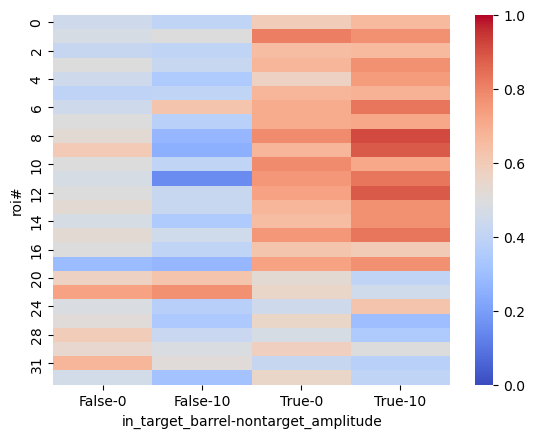

In [16]:
sns.heatmap(scores,vmin = 0, vmax = 1, cmap = "coolwarm")

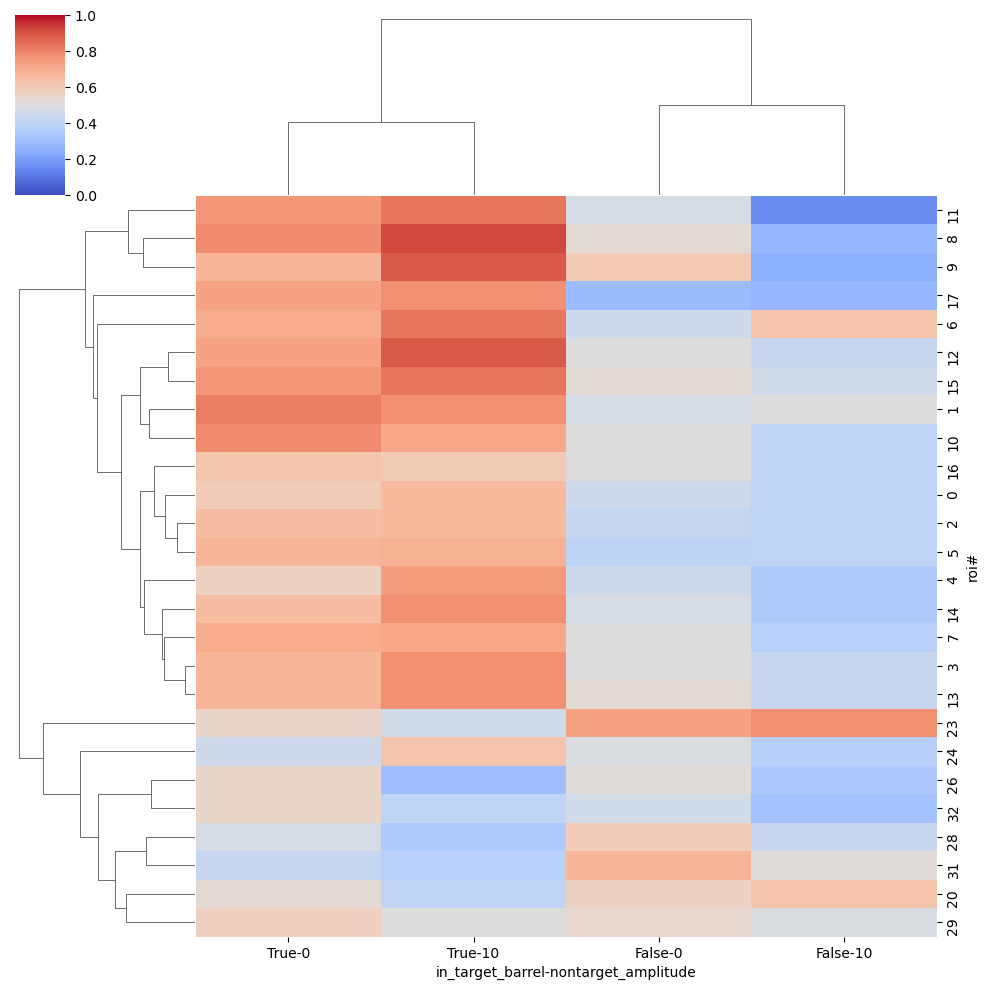

In [17]:
sns.clustermap(scores,vmin = 0, vmax = 1, cmap = "coolwarm")

In [43]:
scores = scores.replace({True: 1, False: 0})
scores.columns = pd.factorize(scores.columns)[0] 
scores

0         1         2         3
roi#                                        
0     0.447368  0.400000  0.621622  0.685714
1     0.473684  0.475000  0.810811  0.771429
2     0.394737  0.400000  0.648649  0.685714
3     0.447368  0.450000  0.648649  0.771429
4     0.421053  0.325000  0.540541  0.742857
5     0.394737  0.350000  0.675676  0.714286
6     0.421053  0.650000  0.702703  0.828571
7     0.447368  0.375000  0.702703  0.714286
8     0.526316  0.275000  0.783784  0.885714
9     0.578947  0.275000  0.675676  0.885714
10    0.552632  0.400000  0.783784  0.714286
11    0.447368  0.150000  0.729730  0.828571
12    0.500000  0.400000  0.783784  0.885714
13    0.473684  0.425000  0.675676  0.771429
14    0.473684  0.375000  0.648649  0.771429
15    0.526316  0.425000  0.756757  0.828571
16    0.500000  0.400000  0.567568  0.600000
17    0.263158  0.300000  0.729730  0.771429
18    0.613333  0.533333       NaN       NaN
19    0.653333  0.533333       NaN       NaN
20    0.567568  0.628571  0.552632  0.400000
21    0.600000  0.533333       NaN       NaN
22    0.600000  0.480000       NaN       NaN
23    0.729730  0.771429  0.552632  0.450000
24    0.486486  0.371429  0.473684  0.600000
25    0.533333  0.426667       NaN       NaN
26    0.540541  0.342857  0.578947  0.300000
27    0.560000  0.493333       NaN       NaN
28    0.567568  0.400000  0.447368  0.325000
29    0.594595  0.428571  0.578947  0.525000
30    0.506667  0.493333       NaN       NaN
31    0.675676  0.542857  0.394737  0.375000
32    0.459459  0.314286  0.578947  0.425000
33    0.586667  0.520000       NaN       NaN
34    0.440000  0.546667       NaN       NaN